<a href="https://colab.research.google.com/github/RenaAbbasova/Ejemplo_Rena/blob/master/Estambul_Data_StoryTelling_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Estambul, antiguamente conocida como Bizancio y Constantinopla, es la ciudad más poblada de Turquía y el centro histórico, cultural y económico del país. Es una ciudad transcontinental, ubicada en el estrecho del Bósforo, que separa Europa y Asia, entre el mar de Mármara y el mar Negro.
Desde un sitio web Insideairbnb.com en el que se publican conjuntos de datos extraídos de la web de "instantáneas" de ciudades. He descargado los archivos de Estambul de la situación del 29 March, 2022. Pienso que es un conjunto de datos interesante para trabajar. Además de la disputa de datos básicos y las tramas, también he agregado **mapas interactivos de Folium, gráficos interactivos de tramas y extracción de texto de los comentarios de revisión.*






#1. Importando módulos y datos

## 1.1 Importar módulos

In [1]:
!pip install geopandas  # instalamos geopandas para trabajar de longitud y latitude 
!pip install chart_studio # instalamos chart_studio para crear gráficos interactivos 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 407 kB/s 
     |████████████████████████████████| 6.3 MB 40.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 73 kB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=ce0db8f43008582654593da7012af6f987ec45dda08c4794151f8d50d2e46491
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Create folder
!mkdir input/
# Download file listings_details.csv
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/data/listings.csv.gz -P input/ \
    && gunzip input/listings.csv \
    && mv input/listings.csv input/listings_details.csv
# Download file calendar.csv
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/data/calendar.csv.gz -P input/ \
    && gunzip input/calendar.csv
# Download file reviews_details.csv
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/data/reviews.csv.gz -P input/ \
    && gunzip input/reviews.csv \
    && mv input/reviews.csv input/reviews_details.csv
# Download rest of the files
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/visualisations/listings.csv -P input/
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/visualisations/reviews.csv -P input/  
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/visualisations/neighbourhoods.csv -P input/
!wget http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/visualisations/neighbourhoods.geojson -P input/

--2022-08-26 13:02:01--  http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.94.90
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.94.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12236639 (12M) [application/x-gzip]
Saving to: ‘input/listings.csv.gz’

listings.csv.gz     100%[===================>]  11.67M  36.7MB/s    in 0.3s    

2022-08-26 13:02:01 (36.7 MB/s) - ‘input/listings.csv.gz’ saved [12236639/12236639]

--2022-08-26 13:02:02--  http://data.insideairbnb.com/turkey/marmara/istanbul/2022-03-29/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.94.90
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.94.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24388791 (23M) [application/x-gzip]
Saving to: ‘input/calendar.csv.gz’

calendar.csv.gz     100%[=========

#1.2 Detalles del listado de viviendas
El conjunto de datos contiene un total de 7 archivos. El archivo de listados es un archivo de descripción general que las etiquetas internas de airbnb como "bueno para visualizaciones". El identificador único en el conjunto de datos es la identificación de "listings". Esta es básicamente la identificación del anuncio. En general, había 24864 listados de Airbnb en Istambul en 29 March, 2022.

In [5]:
print(os.listdir("input")) 

['calendar.csv', 'neighbourhoods.geojson', 'listings_details.csv', 'neighbourhoods.csv', 'listings.csv', 'reviews.csv', 'reviews_details.csv']


In [6]:
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False) 
calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews_details.csv", parse_dates=['date'])

In [7]:
listings = pd.read_csv("input/listings.csv", index_col= "id")

In [8]:
print(listings.shape) # Number of entries and columns 

(24864, 17)


El archivo de listados contiene 17 variables por listado además del id.

In [9]:
listings.columns 

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

El archivo listados_detalles contiene un total de 73 variables. No vamos a usar todos estos, sino que juntaremos selectivamente una serie de variables que parecen útiles para este EDA.

In [10]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',

In [11]:
target_columns = ['host_location','host_about','host_response_time', 'host_response_rate', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_value', 'review_scores_location','property_type','accommodates', 'review_scores_communication', 'maximum_nights']
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24864 entries, 20815 to 52068820
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            24842 non-null  object 
 1   host_id                         24864 non-null  int64  
 2   host_name                       24863 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   24864 non-null  object 
 5   latitude                        24864 non-null  float64
 6   longitude                       24864 non-null  float64
 7   room_type                       24864 non-null  object 
 8   price                           24864 non-null  int64  
 9   minimum_nights                  24864 non-null  int64  
 10  number_of_reviews               24864 non-null  int64  
 11  last_review                     14075 non-null  object 
 12  reviews_per_month        

Vemos que el neighbourhood_group y  license   es inútil en Estambul, ya que contiene cero objetos no nulos. A continuación, nos deshacemos de esta variable y mostramos el encabezado del marco de datos con el que vamos a trabajar.

In [12]:
listings = listings.drop(columns=['neighbourhood_group', 'license'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))
listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_value,review_scores_location,property_type,accommodates,review_scores_communication,maximum_nights
id,,,,,,,,,,,,,,,,,,,,,
20815,The Bosphorus from The Comfy Hill,78838,Gülder,Besiktas,41.06976,29.04379,Entire home/apt,1764,365,41,...,4.50,4.70,4.52,4.85,4.50,4.79,Entire rental unit,3,4.91,900
220131,Charming Delightful Studio@Centre 4,466302,Demir,Beyoglu,41.02802,28.97515,Entire home/apt,649,30,83,...,4.64,4.69,4.65,4.83,4.66,4.94,Entire rental unit,3,4.84,365
33368,Deluxe double bedroom @ Nisantasi,135136,Ozlem,Sisli,41.05376,28.99876,Private room,859,2,1,...,5.00,5.00,5.00,5.00,5.00,5.00,Private room in rental unit,2,5.00,15
27271,Lovely apartment in perfect location,117026,Mutlu,Beyoglu,41.03254,28.98153,Entire home/apt,816,10,3,...,5.00,5.00,4.67,5.00,5.00,5.00,Entire rental unit,2,5.00,90
34177,PETIT HOUSE,147330,Ercan,Besiktas,41.06681,29.04035,Entire home/apt,599,10,9,...,4.86,4.86,5.00,5.00,4.71,4.71,Entire home,3,5.00,365


# 2. Análisis exploratorio
## 2.1 Vecindario




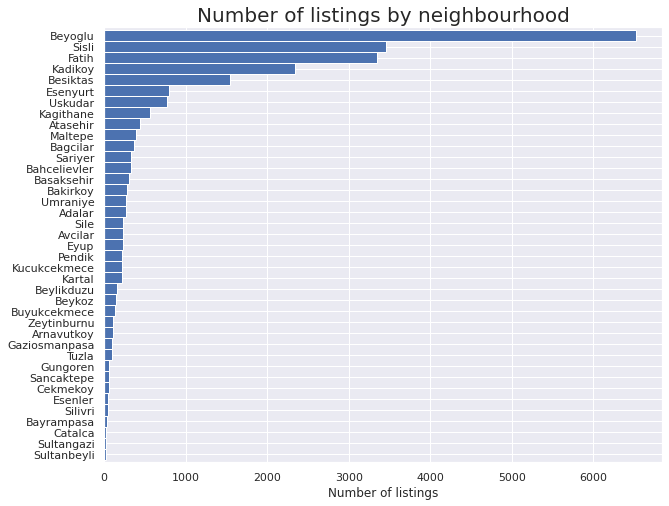

In [13]:
data=listings['neighbourhood'].value_counts().sort_values(ascending=True)
data.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

Estsmbul se encuentra ubicada en el noroeste del pais, a orillas del Bósforo, estrecho que separa fisicamente Europa y Ásia. A continuación, puede ver que la mayoría de los listados están tanto en una como en la otra parte. Principalmente en las zonas costeras. Este mapa es interactivo y puede ampliar los grupos para encontrar las ubicaciones individuales de los listados.



In [14]:
lats1 = listings['latitude'].tolist()
lons2 = listings['longitude'].tolist()
locations = list(zip(lats1, lons2))

map1 = folium.Map(location=[41.01325, 28.97945], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2.2 Tipos de propiedades y habitaciones

### 2.2.1 Tipos de habitaciones

Estambul es uno de los destinos más populares del mundo para Airbnb debido a su sector turístico. Independientemente del clima, el intenso turismo en Estambul y las costas activas del Mediterráneo y el Egeo durante el verano aumentó la necesidad de viviendas, lo que hizo que las aplicaciones de vivienda como Airbnb fueran más populares y reconocibles en Turquía.
Airbnb Turquía le permite alquilar toda su casa o solo una habitación de la casa. A continuación podemos ver que tipo de propiedad son más usados.

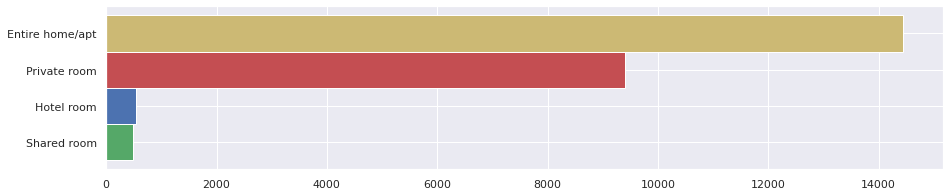

In [15]:
data = listings['room_type']. value_counts().sort_values(ascending=True)
data.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r","y"])
plt.show()

### 2.2.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [16]:
listings.property_type.unique()

array(['Entire rental unit', 'Private room in rental unit', 'Entire home',
       'Entire serviced apartment', 'Entire villa',
       'Private room in home', 'Entire loft', 'Entire condo',
       'Private room in loft', 'Shared room in rental unit',
       'Entire bed and breakfast', 'Room in serviced apartment',
       'Shared room in home', 'Private room in condo', 'Camper/RV',
       'Private room in villa', 'Private room in chalet',
       'Private room in serviced apartment', 'Private room in townhouse',
       'Room in aparthotel', 'Room in boutique hotel', 'Farm stay',
       'Private room in bed and breakfast', 'Private room',
       'Shared room in condo', 'Entire townhouse', 'Entire chalet',
       'Room in hotel', 'Shared room in loft', 'Shared room in hotel',
       'Tiny home', 'Private room in yurt', 'Room in hostel',
       'Room in bed and breakfast', 'Entire place',
       'Private room in treehouse', 'Shared room in hostel',
       'Private room in hostel', 'Tent', 'E

En la figura a continuación, solo mostramos tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Estambul son apartamentos y casas enteras, tambien habitaciones privadas.


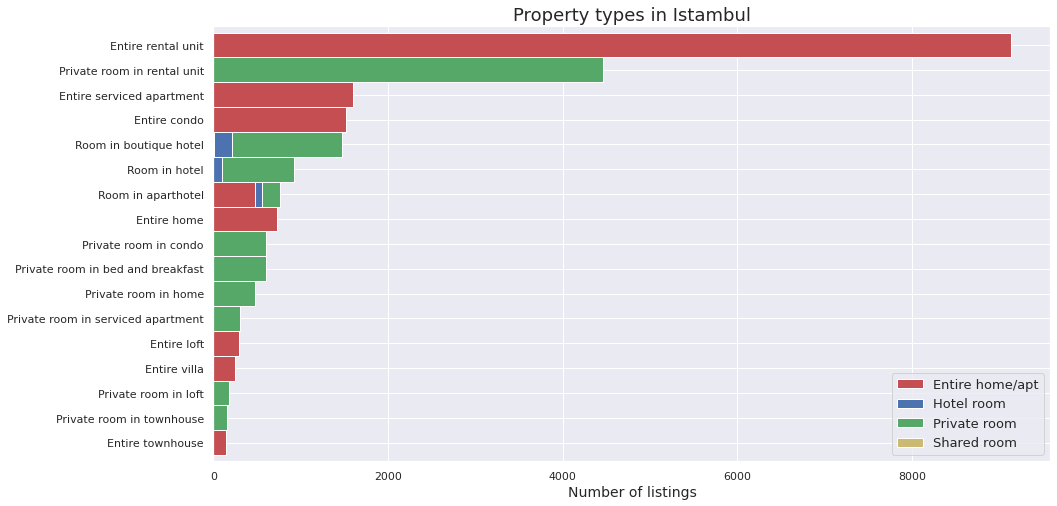

In [17]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g", "y"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Istambul', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Número de alojados

la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio.

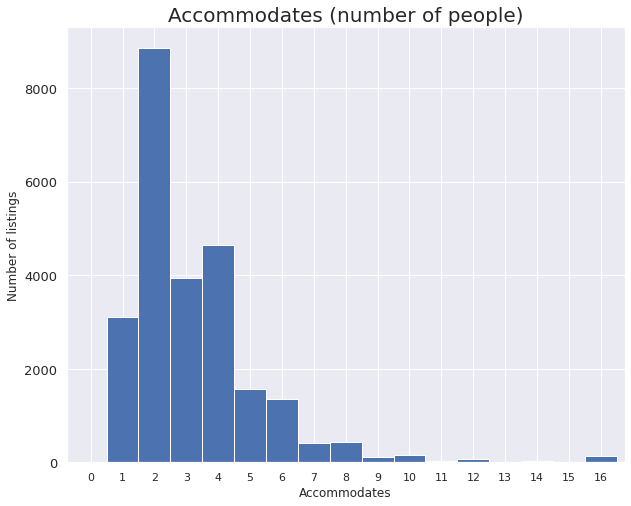

In [18]:
data=listings['accommodates'].value_counts().sort_index()
data.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

## 3. Encontrando potenciales hoteles ilegales



A continuación, mostramos los cinco anfitriones que tienen la mayor cantidad de listas de salas privadas. Airbnb no proporciona las direcciones de los listados.

In [19]:
private = listings[listings['room_type'] == "Private room"]  
host_private = private.groupby(['host_id', 'host_name', 'host_location']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,host_location,private_rooms
1166,45788344,Dorothy,"Fethiye, Muğla, Turkey",208
2462,189516806,Arzu,"İstanbul, İstanbul, Turkey",27
4789,376388906,The Bold,TR,23
2420,185171232,Hakan,"İstanbul, İstanbul, Turkey",21
970,35882848,Günay,"İstanbul, İstanbul, Turkey",18


Sin embargo, tenemos las coordenadas GPS de los listados. Por ello, parece muy probable que todas las habitaciones privadas que ofrece Dorothy estén en el mismo edificio (solo variaciones menores en latitud/longitud). Aunque este anfitrión podría tener una licencia de hotel

In [20]:
Dorothy = private[private['host_id']== 45788344]
Dorothy = Dorothy[['name','host_id', 'host_name', 'latitude', 'longitude']]
Dorothy.index.name = "listing_id"
Dorothy

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
35704096,HOLIDAY INN İSTANBUL CITY HOTEL,45788344,Dorothy,41.019010,28.927450
35704784,HOTEL ERDEN SARAYEVO,45788344,Dorothy,41.008480,28.956530
35705350,AJWA HOTELS CITY VIEW ROOM,45788344,Dorothy,41.005530,28.970380
35705747,AKGÜN HOTEL STANDARD ROOM,45788344,Dorothy,41.023320,28.931450
35706563,ALL SEASONS HOTEL İSTANBUL,45788344,Dorothy,41.013640,28.939890
...,...,...,...,...,...
569361117982600534,The Galata Port Hotel -Economy Double Room BB,45788344,Dorothy,41.024368,28.974032
569384778904565662,Prestige Hotel Old City-Standard Single Room BB,45788344,Dorothy,41.008209,28.956846
569384779812448328,The Galata Port Hotel-SNG Economy Room BB,45788344,Dorothy,41.024510,28.973689


In [21]:
Dorothy[['latitude', 'longitude']].mean()

latitude     41.028846
longitude    28.946959
dtype: float64

## 3.2 Efectos no deseados de los anfitriones profesionales?



Airbnb se considera un "servicio turístico profesional" en Estambul en lugar de una forma de compartir su hogar.
Los anfitriones de Airbnb en Estambul deben tener una 'licencia de operación turística'. Esto es fácil de conseguir para una casa pero no para un apartamento.
Los anfitriones deben obtener la aprobación de todos en el edificio o registrar el piso como lugar de trabajo, en lugar de residencia. 
El propietario del apartamento también debe declarar el lugar a la oficina de impuestos.
Un lugar de Airbnb sin licencia terminaría siendo cerrado y sellado hasta que se adquiera dicha licencia. Además, se aplicaría una multa fiscal al propietario.

No permitido: la vivienda pública no se puede alquilar por menos de seis meses

In [22]:
data = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = data.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,42,46,57,67,72,79,92,100,110,209
count,9846,1398,551,343,233,148,106,78,45,49,...,1,1,1,2,1,1,1,1,1,1


A continuación, mostramos los anfitriones con más de 20 listados. Como puede ver anfitrión con muchos listados, claramente un anfitrión profesional.
Como anfitrión de Airbnb, no enfrentará ningún problema siempre que cumpla con sus responsabilidades en materia de impuestos legales de Airbnb y algunas otras obligaciones correctamente.



In [23]:
data = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
data = data.sort_values(by=['num_host_listings'], ascending=False)
data = data[data['num_host_listings'] >= 20]
data

,host_id,host_name,host_about,num_host_listings
1717,45788344,Dorothy,I was born in 1978 in Izmir. After I have grad...,209
1184,21636586,VNG Property,"We established VNG Property in 2018, specializ...",100
3031,223450420,Mehmet,Hello and welcome! \n\nI am happy to be part o...,92
3717,290856747,Raju,Merhaba and welcome! This is Raju who loves tr...,79
1196,21907588,Zeynep,"Greetings from Istanbul :) This is Zeynep, bor...",72
2922,213157136,Ghassan,My name is Ghasan and I’m 35 .. My fav sport i...,67
4159,365900986,Newinn,Whether you are planning a trip to Istanbul fo...,67
1115,19798022,Wonder,"Hi all, \nWe have a team of 10 dedicated to in...",57
849,11635163,Güner-Berivan,"Hello, this is Güner, welcome to our Family-ru...",41
2503,157100965,Ahmet,"""ORYAPARK Furnished Apartment Rentals"" provide...",40


In [24]:
data['host_about'].iloc[1]


'We established VNG Property in 2018, specializing in home rentals in Istanbul, Turkey. We wanted to give foreigners a vibrant and unique experience living in our favorite city! Since founding VNG we have been scouting the best homes with character and comfort for guests to experience and live like a true local. Today, visitors can choose from a wide variety of homes to enjoy from.\n\nOur mission is to keep building our company organically. Our values are based on quality, service and local expertise. \n\nWe go above and beyond for guests. A friendly face to greet you, custom made linen sheets, towels and toiletries all taken care of at a high level. We are available 24/7 if you need us.\n\nWe also provide airport transfer, extra house keeping, cruises and tours to name a few of our extra services.\n\nPlease note: Because we are a legal company we require all guests to provide I.D. verification at check-in to complete the check-in process to comply with government rules and regulations

# 4. Consejos al turismo

## 4.1 Precio medio por vecindario

Para comparar "manzanas con manzanas" solo seleccionaremos el tipo de alojamiento más común, que es el alojamiento para 2 personas.
Estambul no es una ciudad con un centro como tal, sino muchos ciudades con diferentes centros. El grafico nos muestra que la ciudad  Beykoz es la mas cara.

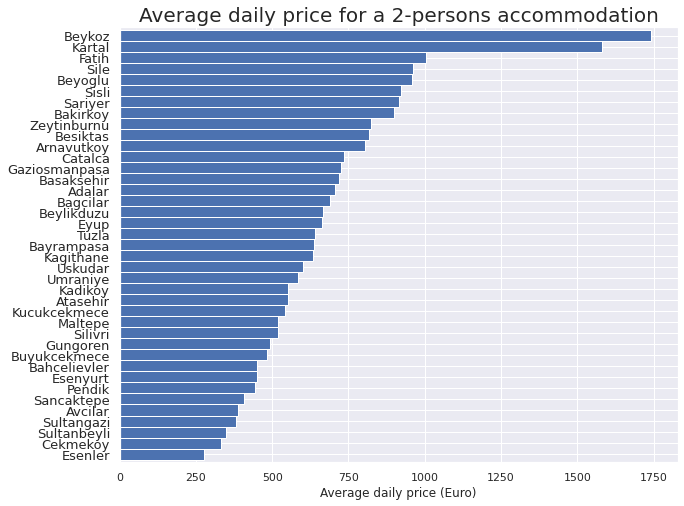

In [25]:
data = listings[listings['accommodates']==2]
data = data.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
data.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

#4.2 Seguridad del vecindario
Como no hay datos sobre la seguridad del vecindario en los archivos de Airbnb,  Como puedes ver es preferible por ejemplo quedarse en el barrio de Beyoğlu,
aunque en general Estambul es una ciudad no peligrosa.

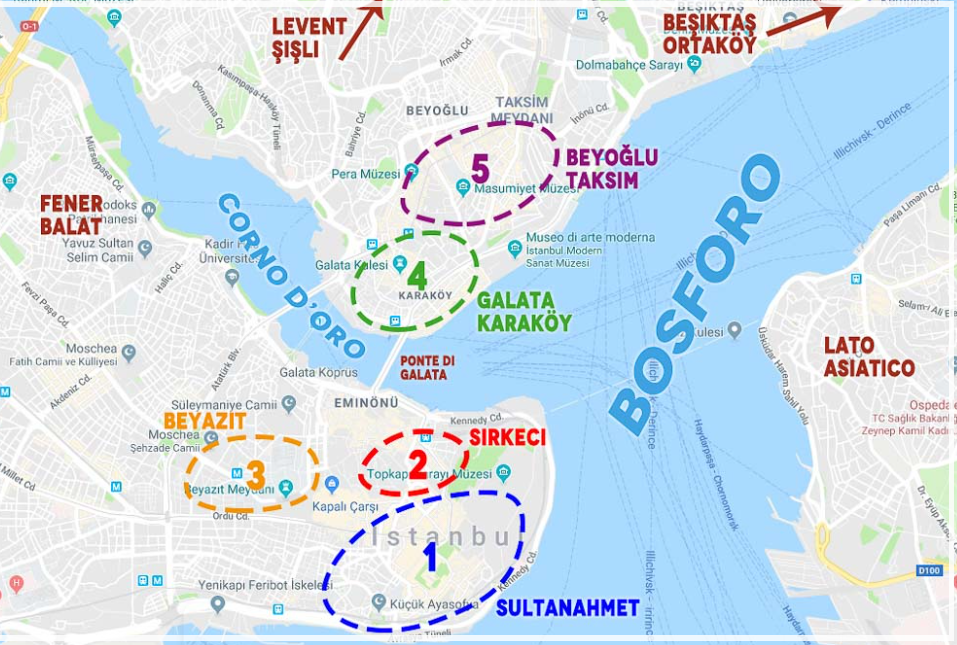

A continuación puede encontrar los barrios en un mapa. Este mapa es **interactivo**. Al pasar el cursor sobre los polígonos se muestra el nombre del barrio y el precio medio de los alojamientos para 2 personas.

In [26]:
adam = gpd.read_file("input/neighbourhoods.geojson")
data = pd.DataFrame([data])
data = data.transpose()
adam = pd.merge(adam, data, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

In [27]:
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[41.01325, 28.97945], zoom_start=11)
folium.GeoJson(data=adam,
               name='Estambul',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

## 4.3 Review scores location, and location scores versus price

En esta sección, agrupamos los puntajes de revisión de la ubicación por vecindario (solo listados con al menos 10 revisiones). Aunque esperamos que la distancia al centro de la ciudad sea un factor importante, esta puntuación también debería tener en cuenta otras cosas. Otros factores pueden incluir:

* La seguridad de una ubicación (como se muestra en la sección anterior)
* Ruido. Si una lista tiene una ubicación central, pero está rodeada de bares ruidosos, eso debería costar puntos en el puntaje de revisión de la ubicación.
* Si un listado está ubicado fuera del centro de la ciudad pero bien conectado por transporte público, debería obtener puntos de bonificación por eso.
* Instalaciones cercanas al listado. ¿Hay supermercados, bares y restaurantes cerca?


A continuación, vemos que los vecindarios, que generalmente también fueron los más caros, no obtienen una puntuación más alta en la puntuación de revisión de ubicación.  
No tiene una conrrelación fuerte entre localización y precio. 


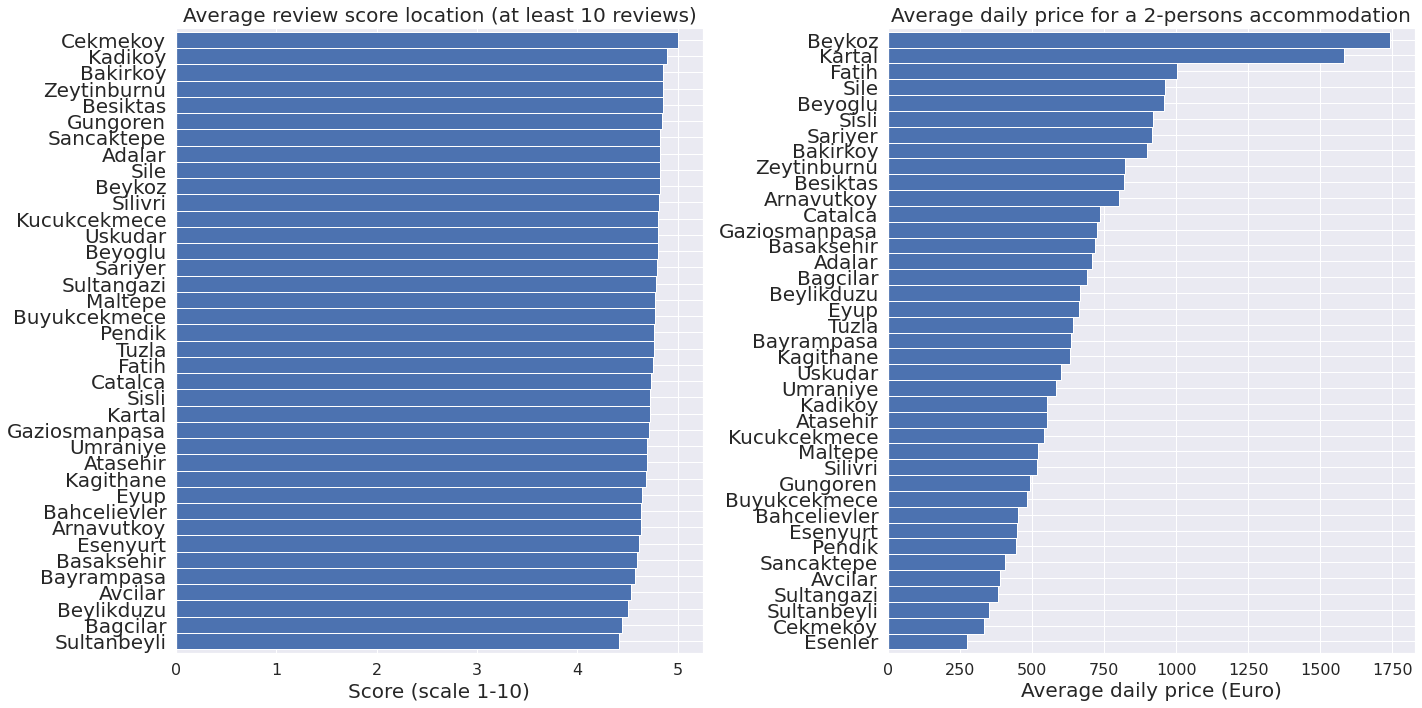

In [28]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.4 Cómo usar las puntuaciones de las opiniones

Además de las reseñas escritas, los invitados pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría. Los huéspedes pueden dar calificaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

A continuación puede ver la distribución de puntajes de todas esas categorías. Está bien explicado en este artículo: [¿Más alta que la calificación promedio? El 95 % de los listados de Airbnb calificaron de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Después de haber visto las distribuciones de puntajes, personalmente consideraría que cualquier puntaje de 3 o inferior no es un buen puntaje.

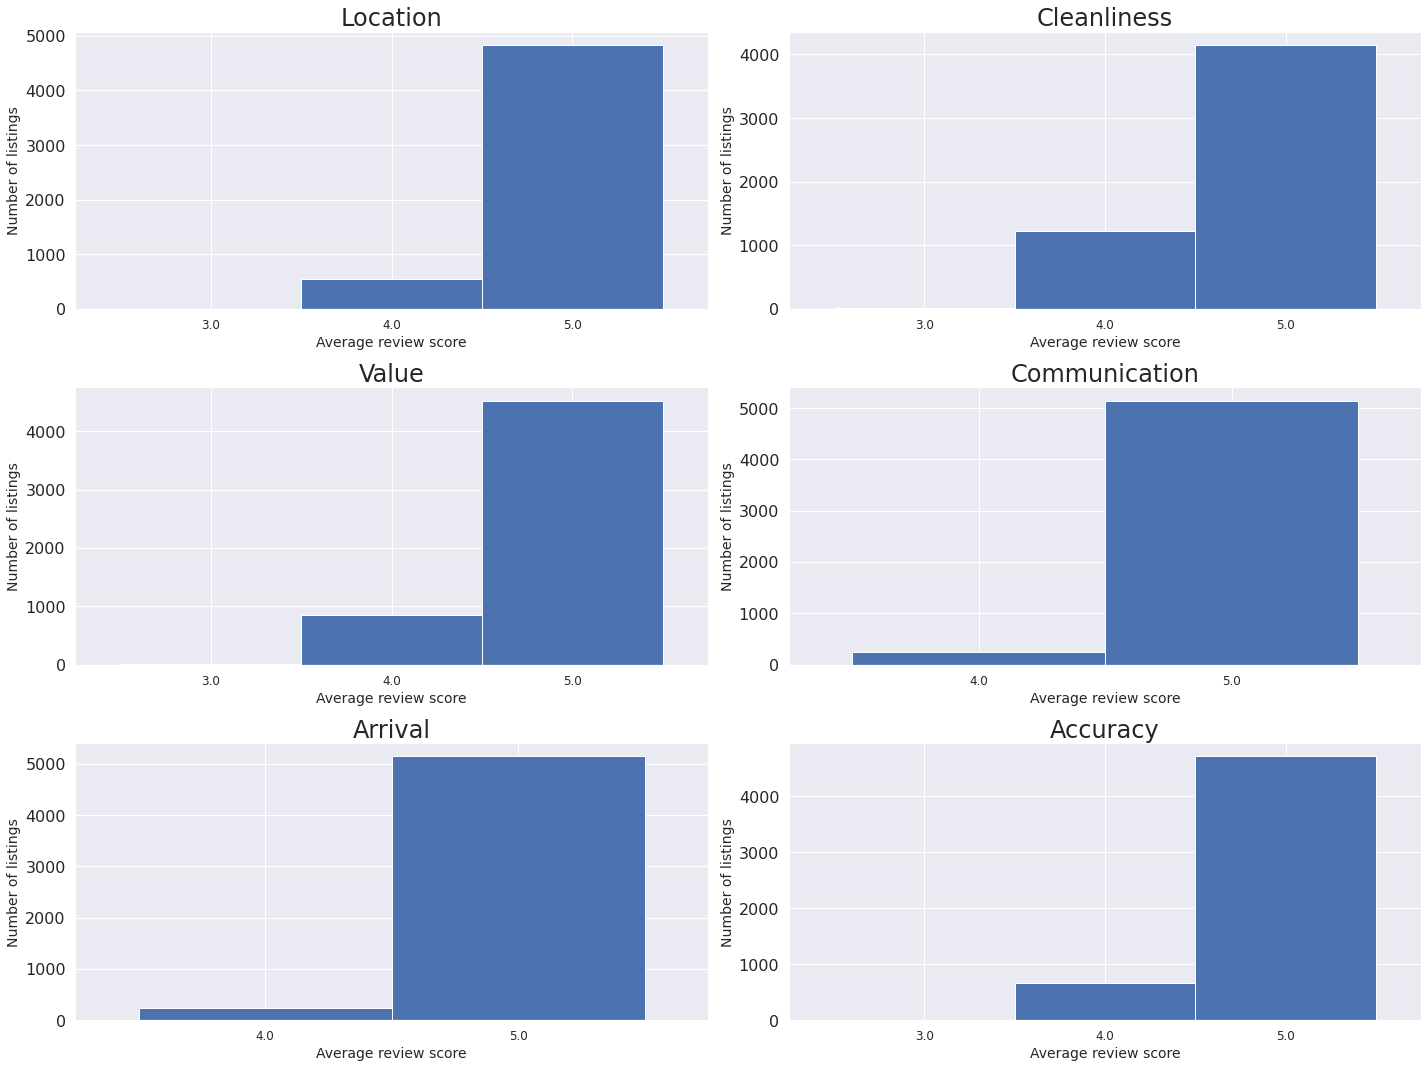

In [29]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].round().value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].round().value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].round().value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].round().value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].round().value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].round().value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

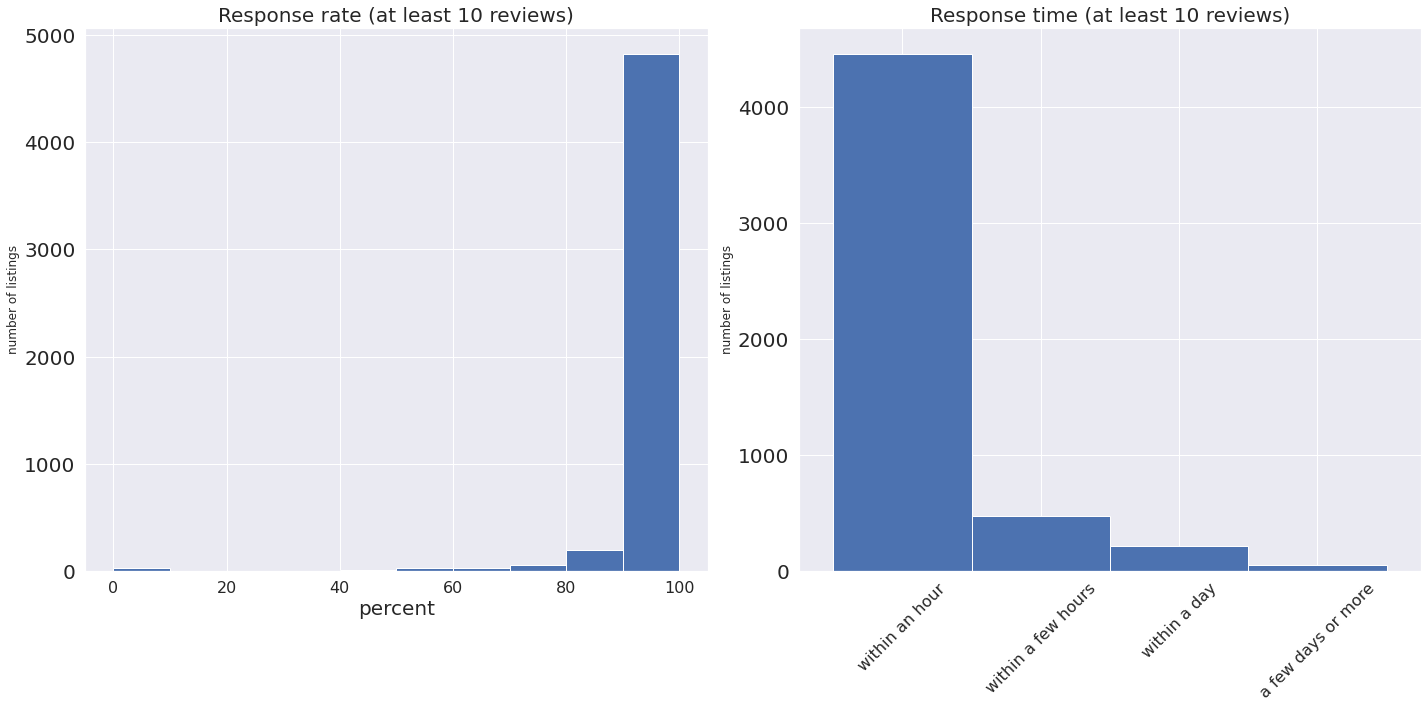

In [30]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

## 4.5 Disponibilidad en el tiempo

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [31]:
calendar.date.values[0]

numpy.datetime64('2022-03-30T00:00:00.000000000')

In [32]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2023-03-29']
#calendar = calendar.drop(['adjusted_price',	'minimum_nights',	'maximum_nights'],axis=1)

In [33]:
print(calendar.shape)

(9042232, 6)


A continuación se muestra un ejemplo de los datos del calendario. Importante tener en cuenta: la disponibilidad es FALSE significa que el propietario no quiere alquilar su propiedad en la fecha específica o que la lista ya se ha reservado para esa fecha. Como queremos comparar manzanas con manzanas nuevamente con respecto a los precios en la siguiente sección, estamos fusionando la variable 'accomodate' con el calendario.

In [34]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,adjusted_price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,,
51327108,2022-10-25,f,1059.0,"$1,059.00",3.0,1125.0,2
41959043,2023-02-18,t,586.0,$586.00,1.0,1125.0,4
18195219,2023-02-16,f,500.0,$500.00,1.0,2.0,2
49078227,2022-04-28,t,1025.0,"$1,025.00",2.0,1125.0,4
41077561,2022-04-05,t,1000.0,"$1,000.00",1.0,1125.0,4
42614821,2023-02-25,f,250.0,$250.00,1.0,1125.0,2
33736245,2022-12-21,t,813.0,$813.00,2.0,1125.0,3
52991290,2023-03-05,t,136.0,$129.00,1.0,1125.0,10
43093458,2022-11-14,f,979.0,$979.00,2.0,1125.0,3


A continuación, vemos que generalmente hay alojamientos disponibles en el futuro.  Este gráfico es interactivo y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el "número de listados disponibles" y el "día de la semana" por fecha.

In [35]:
import plotly.io as pio
pio.renderers.default = "colab"

In [36]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

figura = sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

In [37]:
!pip show plotly 

Name: plotly
Version: 5.5.0
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: six, tenacity
Required-by: datascience, cufflinks, chart-studio


A continuación, verá el precio promedio de todos los alojamientos para 2 personas marcados como disponibles por fecha. El pico del precio promedio de 1,125 euros es el 2 de enero y el patrón cíclico se debe a precios más altos en los fines de semana. Sin embargo, sospecho que los precios para fechas más lejanas en el tiempo aún no están actualizados y probablemente sean precios predeterminados. Esto podría dar lugar a que el anfitrión no acepte una reserva si se da cuenta de que alguien está intentando reservar algo en una fecha que debería haber sido más cara de lo habitual. Este gráfico es interactivo y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha

In [38]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date')

# 5. Minería de texto con las _reviews_ (opcional)


Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.


In [39]:
reviews_details.shape

(258968, 6)

In [40]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
31174,20815,The Bosphorus from The Comfy Hill,78838,Gülder,2010-03-24,49388,Chuck,My daughter and her friend and I all stayed at...
40738,20815,The Bosphorus from The Comfy Hill,78838,Gülder,2010-05-08,93598,Sara,You cannot find a better place to stay in Turk...
49182,20815,The Bosphorus from The Comfy Hill,78838,Gülder,2010-06-02,108540,Suzan,This comfortable apartment truly deserves the ...
85462,20815,The Bosphorus from The Comfy Hill,78838,Gülder,2010-08-27,126482,William,I second all the excellent reviews of this pla...
89515,20815,The Bosphorus from The Comfy Hill,78838,Gülder,2010-09-03,180502,Pamela,Thanks to Firat and especially Arda for their ...


A continuación, encontrará los 5 hosts con más reseñas. 

In [41]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
21907588,Zeynep,4711
50274213,Yusuf,3787
1605466,Kerem,2661
11635163,Güner-Berivan,2330
17975030,Hikmet,2028


In [42]:
reviews_details.comments.head()

id
31174    My daughter and her friend and I all stayed at...
40738    You cannot find a better place to stay in Turk...
49182    This comfortable apartment truly deserves the ...
85462    I second all the excellent reviews of this pla...
89515    Thanks to Firat and especially Arda for their ...
Name: comments, dtype: object

In [43]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'This comfortable apartment truly deserves the name “Bosphorus Bed and Breakfast.” The view from the panoramic living room windows is a delight for the eyes:  The blue waters of the Bosphorus with the bridge connecting Asia and Europe, picturesque green hills with an interesting mixture of modest and posh neighborhoods, seagulls passing by combined with sounds of the müezzin’s call to prayer and bells from the Greek church nearby, are a special treat for any visitor of Istanbul – especially if, like us, you prefer staying in a quiet place, away from the centers of tourism and hustle and bustle of the city with lots of traffic noise. \r<br/>\r<br/>Arda was a very friendly host, accessible and helpful.  The apartment had everything we needed, including some basic food items like, sugar, condiments, tea, etc. The kitchen was well equipped with enough dishes, a stove with four burners, and a large fridge. We ended up using the cooking facilities less than expected thanks to the plentiful e

Añadimos ahora algo de preprocesamiento

In [44]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
#take out empty comments (530)
import nltk
nltk.download('stopwords')
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'comfortable apartment truly deserves name bosphorus bed breakfast view panoramic living room windows delight eyes blue waters bosphorus bridge connecting asia europe picturesque green hills interesting mixture modest posh neighborhoods seagulls passing combined sounds müezzin s call prayer bells greek church nearby special treat visitor istanbul especially if like us prefer staying quiet place away centers tourism hustle bustle city lots traffic noise br br arda friendly host accessible helpful apartment everything needed including basic food items like sugar condiments tea etc kitchen well equipped enough dishes stove four burners large fridge ended using cooking facilities less expected thanks plentiful eateries minutes hill shopping village arnavutköy however grocers produce sellers stores within easy reach well also prepare food apartment br br if stay summer season make sure pull window screens avoid excessive heat flat stay late may early june group four required us try control 

Veamos cómo implementar un conteo de palabras y emplearlo para crear un *wordcloud*

In [46]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
215,br,199858
93,place,93521
17,great,90560
102,apartment,86200
433,location,75258
94,stay,71946
217,host,56978
88,nice,54466
606,clean,53457
204,istanbul,53023


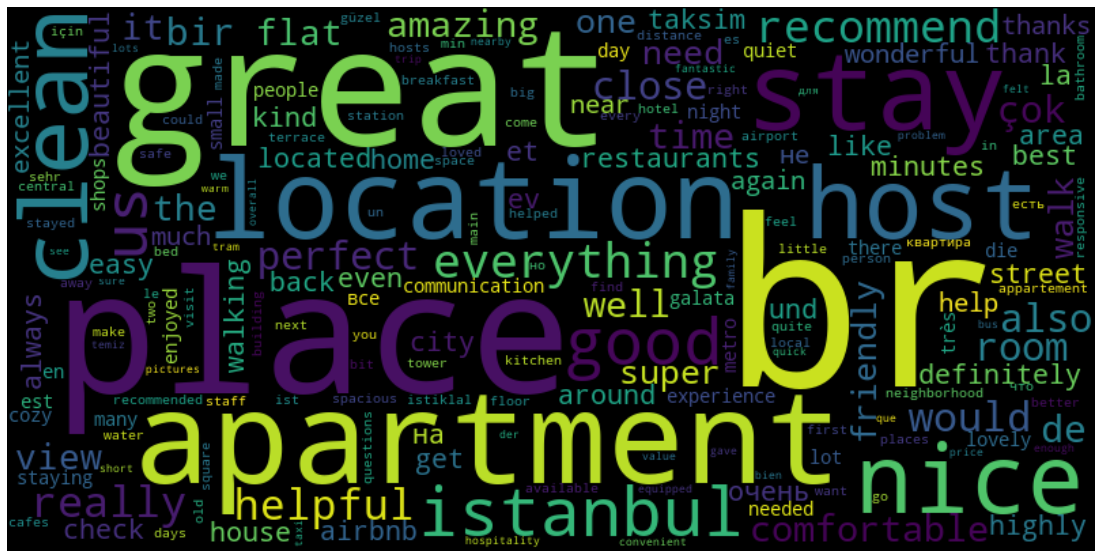

In [47]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()